In [1]:
# Add analysis to the path
import sys
import pathlib
import os
import numpy
import pandas

parent_dir = os.path.join(os.path.abspath(''), "..")
sys.path.append(parent_dir)

import parsers
from pprint import pprint

path_to_results = os.path.normpath(os.path.join(parent_dir, "archive"))
print(path_to_results)
working_dir = os.path.normpath(os.path.join(parent_dir, "working"))
data = parsers.main(path_to_results, working_dir=working_dir)
print("Finished")

/Users/bhanugarg/Documents/school/cs4365/analysis/archive
Extracting 10 top level archives on 4 workers
Finished


In [2]:
print(data.get("ii-mc-b").replicas[0].config())

{'USERNAME': 'jazevedo', 'HOSTS_TYPE': 'physical', 'HARDWARE_TYPE': 'c8220', 'ENABLED_CPUS': 4, 'USE_PATCHED_DOCKER': 1, 'ENABLE_RADVISOR': 0, 'ENABLE_COLLECTL': 1, 'POLLING_INTERVAL': '6s', 'COLLECTION_INTERVAL': 50, 'WEB_HOSTS': 'clnode048.clemson.cloudlab.us', 'POSTGRESQL_HOST': 'clnode054.clemson.cloudlab.us', 'WORKER_HOSTS': 'clnode072.clemson.cloudlab.us', 'MICROBLOG_HOSTS': 'clnode080.clemson.cloudlab.us', 'MICROBLOG_PORT': 9090, 'AUTH_HOSTS': 'clnode062.clemson.cloudlab.us', 'AUTH_PORT': 9091, 'INBOX_HOSTS': 'clnode053.clemson.cloudlab.us', 'INBOX_PORT': 9092, 'QUEUE_HOSTS': 'clnode094.clemson.cloudlab.us', 'QUEUE_PORT': 9093, 'SUB_HOSTS': 'clnode055.clemson.cloudlab.us', 'SUB_PORT': 9094, 'CLIENT_HOSTS': 'clnode095.clemson.cloudlab.us', 'WORKLOAD_CONFIG': 'conf/bursty.yml', 'SESSION_CONFIG': 'conf/session.yml', 'APACHE_PROCESSES': 8, 'APACHE_THREADSPERPROCESS': 4, 'POSTGRES_MAXCONNECTIONS': 175, 'NUM_WORKERS': 32, 'MICROBLOG_THREADPOOLSIZE': 32, 'AUTH_THREADPOOLSIZE': 32, 'INB

In [45]:
import csv
import numpy
import sys
import pandas as pd

class LogEntry:

    def __init__(self, event, ts, sock_fd):
        self._event = event
        self._ts = ts
        self._sock_fd = sock_fd

    def __lt__(self, other):
        return self._ts < other._ts

    def event(self):
        return self._event

    def ts(self):
        return self._ts

    def sock_fd(self):
        return self._sock_fd

    def __repr__(self):
        return "[{event} -- TS: {ts}; SOCK_FD: {sock_fd}]".format(event=self._event, ts=str(self._ts), sock_fd=str(self._sock_fd))

    

def aggregate(test_name, rep_num):
    recvfrom = data.get(test_name).replicas[rep_num].hosts["client"].recvfrom()
    sendto = data.get(test_name).replicas[rep_num].hosts["client"].sendto()
    connect = data.get(test_name).replicas[rep_num].hosts["client"].connect()

    log_entries = []
    for i in range(len(connect)):
        if int(connect[i].port()) == 80:
            log_entries.append(LogEntry("connect", int(connect[i].ts()), int(connect[i].sock_fd())))

    for i in range(len(sendto)):     
        log_entries.append(LogEntry("sendto", int(sendto[i].ts()), int(sendto[i].sock_fd())))

    for i in range(len(recvfrom)):   
        log_entries.append(LogEntry("recvfrom", int(recvfrom[i].ts()), int(recvfrom[i].sock_fd())))

    log_entries.sort()
    requests = []
    for i in range(len(log_entries)):
        if log_entries[i].event() == "connect":
            request = [log_entries[i]]
            j = i + 1
            while j < len(log_entries) and(log_entries[j].event() != "connect"or log_entries[i].sock_fd() != log_entries[j].sock_fd()):
                if log_entries[i].sock_fd() == log_entries[j].sock_fd():
                    request.append(log_entries[j])
                j += 1
            requests.append(request)

    rt_dist = []
    for request in requests:
        if request[-1].ts() - request[0].ts() < 3000000:
            dif = (request[-1].ts() - request[0].ts())/(1000000)
#             rt_dist.append((request[0].ts(), dif))
            rt_dist.append(dif)

    df = pd.DataFrame({test_name:rt_dist})
    return df

In [46]:
df = pd.DataFrame()
output = os.listdir('/Users/bhanugarg/Documents/school/cs4365/analysis/working')
# print(output)

# for i in range(4):
#     df = df.append(aggregate("ii-mc-b", i))
    
# df.plot.hist(bins=12)
# print(df)
dic = {}

for i in output:
    print(i)
    temp = [x for x in os.listdir('/Users/bhanugarg/Documents/school/cs4365/analysis/working/' + i + '/results') if "gz_" in x]
    df = pd.DataFrame()
    test_name = i.split(".",1)[0]
    for j in range(len(temp)):
        df.append(aggregate(test_name, j))
    dic[i] = df


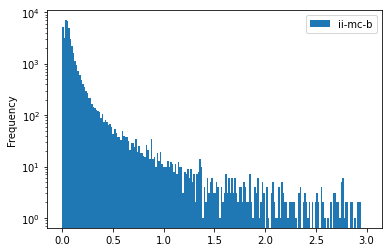

In [62]:
for i in dic:
    i.plot.hist(bins=200, range = (0,3), log = True)

In [43]:
print(df)

        ii-mc-b
0      1.066891
1      0.542460
2      0.733897
3      1.503263
4      0.679330
...         ...
10470  0.125052
10471  0.142359
10472  0.899486
10473  1.301989
10474  0.404246

[42945 rows x 1 columns]


In [53]:
print(df.max())

ii-mc-b    2.939558
dtype: float64


In [54]:
print(df.mean())

ii-mc-b    0.108497
dtype: float64
